## Зубеня ДЗ 6

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [7]:
# Run this cell if you are in Colab
# Else download data https://drive.google.com/file/d/1AdrduuNb83hvi4cQ-1v-ojhjWL1OUAZr/view?usp=sharing
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1AdrduuNb83hvi4cQ-1v-ojhjWL1OUAZr"})   
downloaded.GetContentFile('cityscapes_data.zip')

In [8]:
! unzip cityscapes_data.zip

Archive:  cityscapes_data.zip
   creating: cityscapes_data/
   creating: cityscapes_data/val/
  inflating: cityscapes_data/val/213.jpg  
  inflating: cityscapes_data/val/212.jpg  
  inflating: cityscapes_data/val/211.jpg  
  inflating: cityscapes_data/val/210.jpg  
  inflating: cityscapes_data/val/21.jpg  
  inflating: cityscapes_data/val/209.jpg  
  inflating: cityscapes_data/val/208.jpg  
  inflating: cityscapes_data/val/207.jpg  
  inflating: cityscapes_data/val/206.jpg  
  inflating: cityscapes_data/val/205.jpg  
  inflating: cityscapes_data/val/204.jpg  
  inflating: cityscapes_data/val/203.jpg  
  inflating: cityscapes_data/val/202.jpg  
  inflating: cityscapes_data/val/201.jpg  
  inflating: cityscapes_data/val/200.jpg  
  inflating: cityscapes_data/val/20.jpg  
  inflating: cityscapes_data/val/2.jpg  
  inflating: cityscapes_data/val/199.jpg  
  inflating: cityscapes_data/val/198.jpg  
  inflating: cityscapes_data/val/197.jpg  
  inflating: cityscapes_data/val/196.jpg  
  infla

In [9]:
! jar xvf cityscapes_data.zip

  created: cityscapes_data/
  created: cityscapes_data/val/
 inflated: cityscapes_data/val/213.jpg
 inflated: cityscapes_data/val/212.jpg
 inflated: cityscapes_data/val/211.jpg
 inflated: cityscapes_data/val/210.jpg
 inflated: cityscapes_data/val/21.jpg
 inflated: cityscapes_data/val/209.jpg
 inflated: cityscapes_data/val/208.jpg
 inflated: cityscapes_data/val/207.jpg
 inflated: cityscapes_data/val/206.jpg
 inflated: cityscapes_data/val/205.jpg
 inflated: cityscapes_data/val/204.jpg
 inflated: cityscapes_data/val/203.jpg
 inflated: cityscapes_data/val/202.jpg
 inflated: cityscapes_data/val/201.jpg
 inflated: cityscapes_data/val/200.jpg
 inflated: cityscapes_data/val/20.jpg
 inflated: cityscapes_data/val/2.jpg
 inflated: cityscapes_data/val/199.jpg
 inflated: cityscapes_data/val/198.jpg
 inflated: cityscapes_data/val/197.jpg
 inflated: cityscapes_data/val/196.jpg
 inflated: cityscapes_data/val/195.jpg
 inflated: cityscapes_data/val/194.jpg
 inflated: cityscapes_data/val/193.jpg
 inflate

In [10]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [11]:
data_dir = "cityscapes_data"
train_dir = os.path.join(data_dir, "train") 
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

2975 500


## 2. Analyze data

cityscapes_data/train/1743.jpg


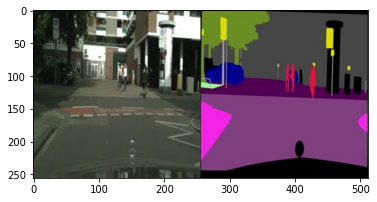

In [12]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

In [13]:
def split_image(image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label

(256, 512, 3)
0 255 0 255


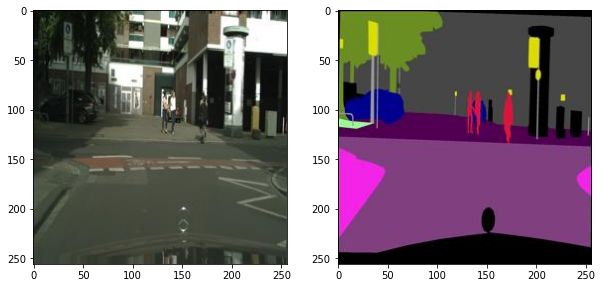

In [14]:
sample_image = np.array(sample_image)
print(sample_image.shape)
cityscape, label = split_image(sample_image)
print(cityscape.min(), cityscape.max(), label.min(), label.max())
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

## 3. Define Labels

In [15]:
"""
color_set = set()
for train_fn in tqdm(train_fns[:10]):
    train_fp = os.path.join(train_dir, train_fn)
    image = np.array(Image.open(train_fp))
    cityscape, label = split_image(sample_image)
    label = label.reshape(-1, 3)
    local_color_set = set([tuple(c) for c in list(label)])
    color_set.update(local_color_set)
color_array = np.array(list(color_set))
"""

num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)
print(color_array[:5, :])

(1000, 3)
[[128 221  86]
 [168   4 109]
 [ 52 248  47]
 [214 249 155]
 [134  20  19]]


In [16]:
num_classes = 10
label_model = KMeans(n_clusters=num_classes)
label_model.fit(color_array)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [17]:
label_model.predict(color_array[:5, :])

array([0, 1, 6, 9, 1], dtype=int32)

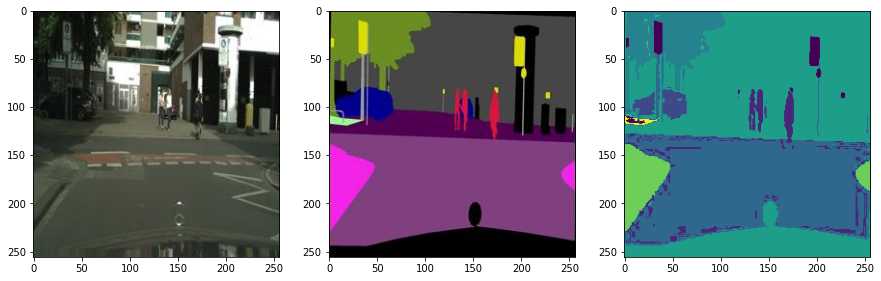

In [18]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

In [19]:
label_class

array([[5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       ...,
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5]], dtype=int32)

## 4. Define Dataset

In [20]:
class CityscapeDataset(Dataset):
    
    def __init__(self, image_dir, label_model):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.label_model = label_model
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = np.array(image)
        cityscape, label = self.split_image(image)
        label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
        cityscape = self.transform(cityscape)
        label_class = torch.Tensor(label_class).long()
        return cityscape, label_class
    
    def split_image(self, image):
        image = np.array(image)
        cityscape, label = image[:, :256, :], image[:, 256:, :]
        return cityscape, label
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [21]:
dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

2975


In [22]:
cityscape, label_class = dataset[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


## 5. Define Model

In [23]:
def conv_block(input,output):
  return nn.Sequential(
      nn.Conv2d(input,output,3,1,1),
      nn.ReLU(),
      nn.BatchNorm2d(output),
      nn.Conv2d(output,output,3,1,1),
      nn.ReLU(),
      nn.BatchNorm2d(output),

  )

In [24]:
class Block_down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_channels),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.MaxPool2d(2),
                nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        return self.block(x)

In [25]:
class Block_down_no_max_pool(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_channels),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_channels),
        )
        

    def forward(self, x):
        return self.block(x)

In [26]:
class Block_up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
        )
    def forward(self, x):
        return self.up(x)

In [27]:
class Block_up_sigm(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels,):
        super().__init__()
        self.up = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
            nn.Sigmoid(),
            nn.BatchNorm2d(out_channels),
        )
    def forward(self, x):
        return self.up(x)

In [28]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        # TODO: Implement Unet layers
        self.down1 = Block_down(3, 32)
        self.down2 = Block_down(32, 64)
        self.down3 = Block_down(64, 128)
        self.down4 = Block_down(128, 256)
        self.down5 = Block_down_no_max_pool(256, 512)
        
        self.up1 = Block_up(512, 256)
        self.up2 = Block_up(256, 128)
        self.up3 = Block_up(128, 64)
        self.up4 = Block_up(64, 32)
        self.up5 = Block_up_sigm(32, num_classes)

   
    def forward(self, X):
        # TODO: Implement Unet forward pass
        fw1 = self.down1(X)
        fw2 = self.down2(fw1)
        fw3 = self.down3(fw2)
        fw4 = self.down4(fw3)
        fw5 = self.down5(fw4)

        fw6 = self.up1(fw5)
        fw7 = self.up2(fw6)
        fw8 = self.up3(fw7)
        fw9 = self.up4(fw8)
        output_out = self.up5(fw9)

        return output_out

In [29]:
model = UNet(num_classes=num_classes)

In [30]:
data_loader = DataLoader(dataset, batch_size=4)
print(len(dataset), len(data_loader))

X, Y = iter(data_loader).next()
print(X.shape, Y.shape)

2975 744
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])


In [31]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


## 6. Train the model

In [32]:
batch_size = 16

epochs = 10
lr = 0.01

In [33]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size=batch_size)

In [34]:
model = UNet(num_classes=num_classes).to(device)

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [36]:
step_losses = []
epoch_losses = []
for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
    epoch_losses.append(epoch_loss/len(data_loader))

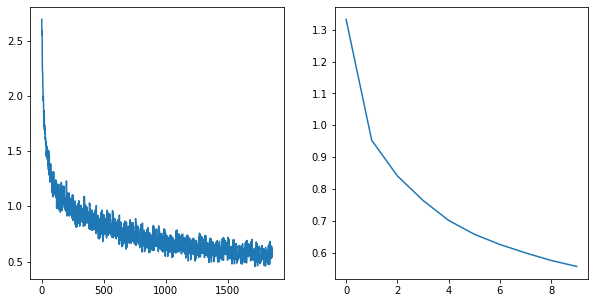

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

In [38]:
model_name = "U-Net.pth"
torch.save(model.state_dict(), model_name)

## 7. Check model predictions

In [39]:
model_path = "U-Net.pth"
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [40]:
test_batch_size = 8
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [41]:
X, Y = next(iter(data_loader))
X, Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([8, 10, 256, 256])
torch.Size([8, 256, 256])


In [42]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

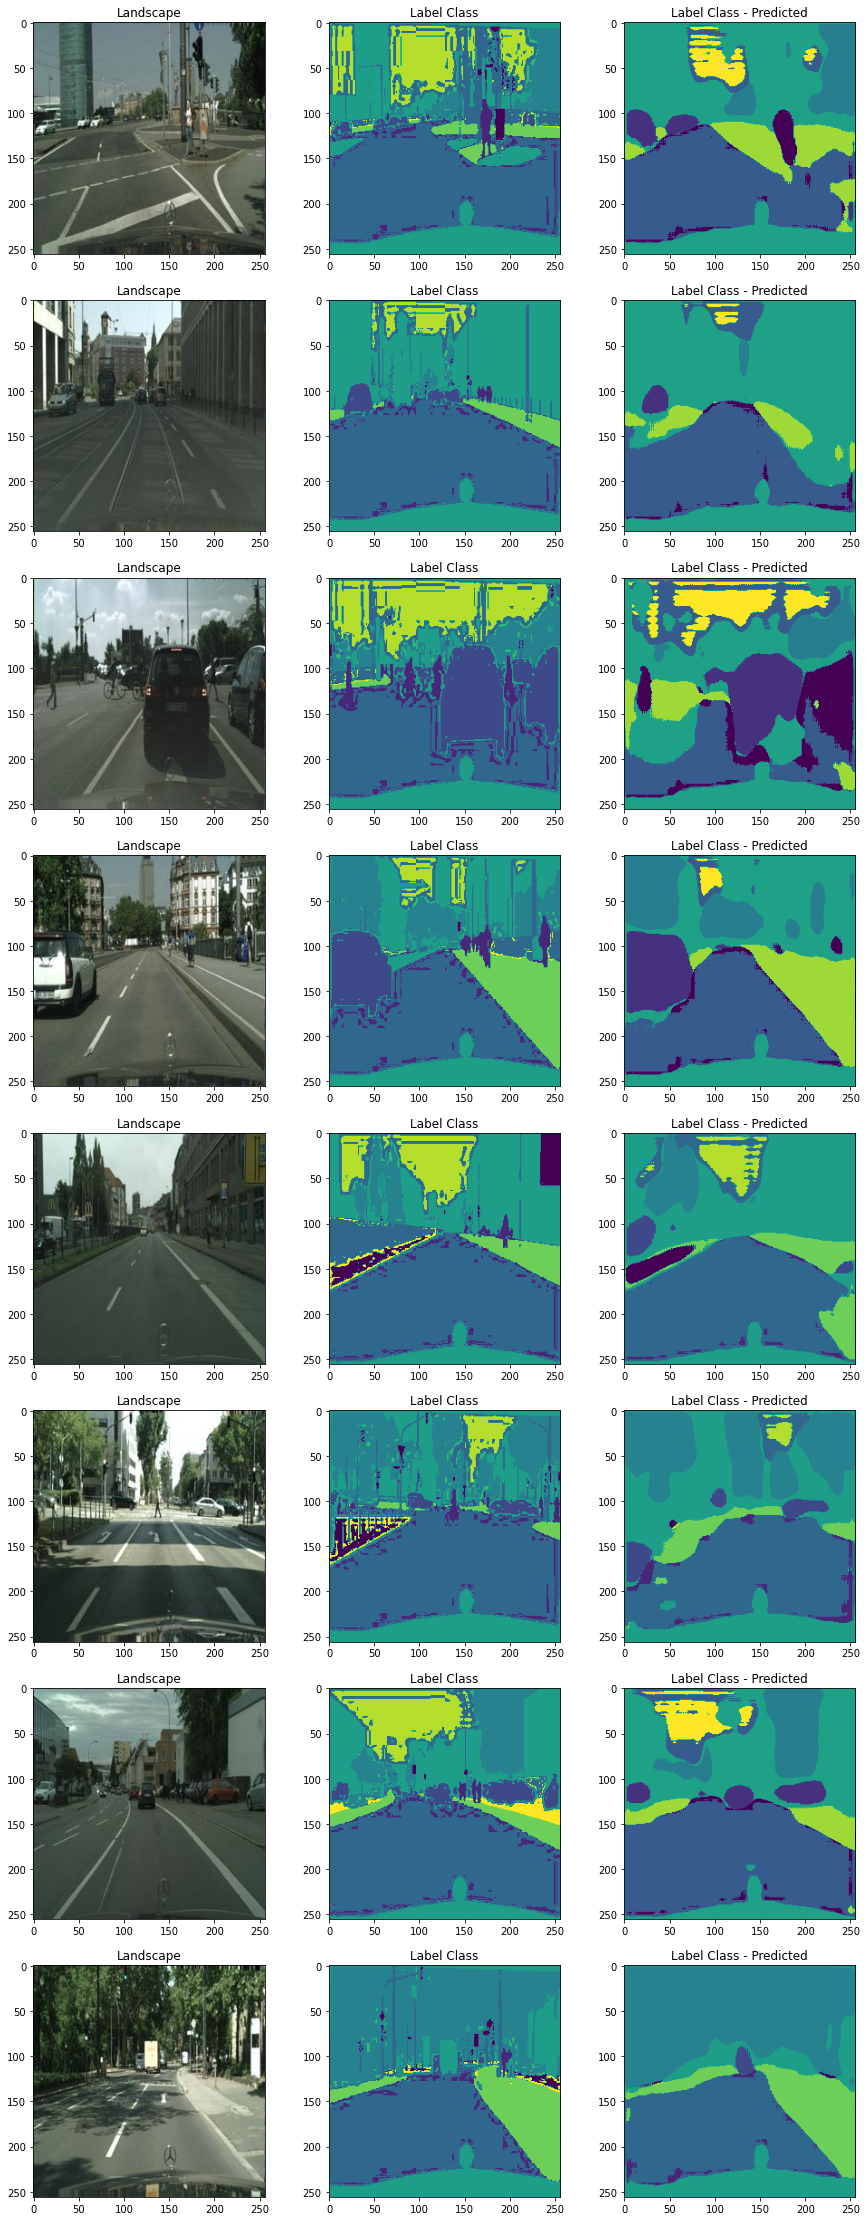

In [43]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")